# Advanced Lane Finding Project

## The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from multiprocessing import Pool
from functools import partial

# Camera Calibration

## Chessboard Image Calibration

In [3]:
def chessboard_calibration(glob_='camera_cal/calibration*.jpg'):
    # Initialize object points, ie. (0,0,0), (1,0,0), (0,1,0), (0,0,1) ...
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object and image points for all the chessboard images.
    objpoints = [] # Object points in 3D space
    imgpoints = [] # Image points in 2D space.
    chessboard_imgs = [] # Array of chessboard images
    
    # Create list of calibration images
    images = glob.glob(glob_)

    # Go through the list and search for corners in chessboard images
    for idx, n_img in enumerate(images):
        img = cv2.imread(n_img)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If object and image points are found then append to earlier array
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Create images with corners marked
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            chessboard_imgs.append(img)
        
    return objpoints, imgpoints, chessboard_imgs

In [4]:
objpoints, imgpoints, chessboard_imgs = chessboard_calibration()

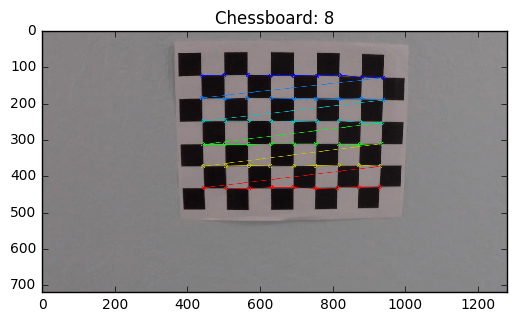

In [5]:
# Create an interactive view of all chessboard images with corners marked
def view_chessboards(chessboards):
    n = len(chessboards)
    def view_image(i):
        plt.imshow(chessboards[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Chessboard: %d' % i)
        plt.show()
    interact(view_image, i=(0,n-1))
    
%matplotlib inline    
view_chessboards(chessboard_imgs)

# Image Distortion Correction

I utilized the CV2 calibrateCamera() function to calculate the camera matrix and distortion coefficients. After I calculated the coefficients I applied them to the test images using the CV2 undistort() function. 

I have included example images of both chessboard and driving images below.

In [6]:
# Camera calibration matrices
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print(img_size)

(1280, 720)


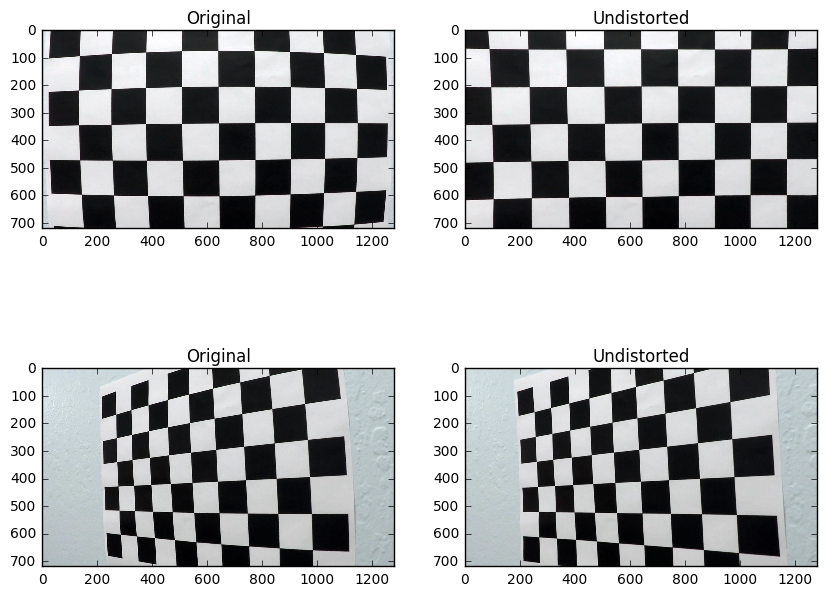

In [7]:
# Examples of undistorted chessboard images
%matplotlib inline

plt.figure(figsize=(10,8))

img1 = cv2.imread("camera_cal/calibration1.jpg")
img2 = cv2.undistort(img, mtx, dist, None, mtx)

plt.subplot(2,2,1)
plt.title('Original')
fig =plt.imshow(img1)

plt.subplot(2,2,2)
plt.title('Undistorted')
fig =plt.imshow(img2)


img3 = cv2.imread("camera_cal/calibration4.jpg")
img4 = cv2.undistort(img3, mtx, dist, None, mtx)

plt.subplot(2,2,3)
plt.title('Original')
fig =plt.imshow(img3)

plt.subplot(2,2,4)
plt.title('Undistorted')
fig =plt.imshow(img4)

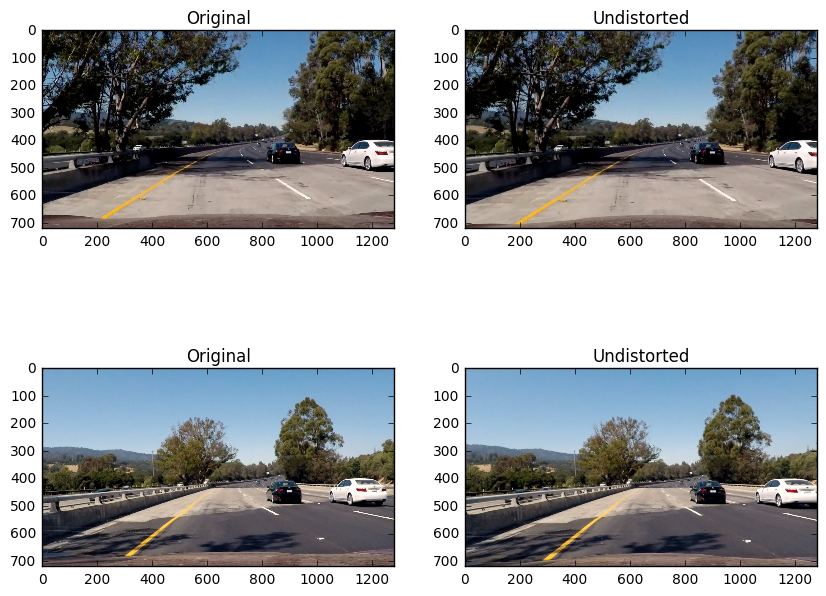

In [8]:
# Examples of undistorted road/driving images
plt.figure(figsize=(10,8))

img_RGB = cv2.imread("test_images/test5.jpg")
img_RGB = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2RGB)
img_RGB2 = cv2.undistort(img_RGB, mtx, dist, None, mtx)

plt.subplot(2,2,1)
plt.title('Original')
fig =plt.imshow(img_RGB)

plt.subplot(2,2,2)
plt.title('Undistorted')
fig =plt.imshow(img_RGB2)

img_RGB3 = cv2.imread("test_images/test4.jpg")
img_RGB3 = cv2.cvtColor(img_RGB3, cv2.COLOR_BGR2RGB)
img_RGB4 = cv2.undistort(img_RGB3, mtx, dist, None, mtx)

plt.subplot(2,2,3)
plt.title('Original')
fig =plt.imshow(img_RGB3)

plt.subplot(2,2,4)
plt.title('Undistorted')
fig =plt.imshow(img_RGB4)

# Threshold Binary Images


I experimented with various threshold methods which were used to create binary images to detect lanelines. The following functions performed reasonably well. Ultimately I ended up using a combination of color and gradient thresholding to process the final images/videos.

## Threshold Methods:
- HSV color space 
- Gradient in HLS color space (Sobel X direction)
- Gradient in in Grayscale (Sobel X and Y direction)
- Color Threshold (yellow and white)

In [38]:
# HSV Threshold
def HSV_thresh(img, thresh_min, thresh_max):
    # Convert to HSV color space
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Create a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(img_HSV[:,:,0] >= thresh_min[0]) & (img_HSV[:,:,0] <= thresh_max[0]) & (img_HSV[:,:,1] >= thresh_min[1])  & (img_HSV[:,:,1] <= thresh_max[1])  & (img_HSV[:,:,2] >= thresh_min[2]) & (img_HSV[:,:,2] <= thresh_max[2])] = 1    
    return binary_output

# Sobel X Threshold
def sobel_x_thresh(img, sobel_kernel=3, min_thresh = 20, max_thresh =100):
    # Convert to HLS color space
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Take the gradient in x using channels L and S from HLS
    sobelx = cv2.Sobel(img_HLS[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(img_HLS[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    # Scale to 8-bit (0 - 255) and convert to uint8
    scaled_sobelx = np.uint8(255*sobelx / np.max(sobelx))
    scaled_sobelx2 = np.uint8(255*sobelx2 / np.max(sobelx2))

    # Create a binary mask with thresholds
    binary_sobelx = np.zeros_like(scaled_sobelx)
    binary_sobelx[(scaled_sobelx >= min_thresh) & (scaled_sobelx <= max_thresh)] = 1

    binary_sobelx2 = np.zeros_like(scaled_sobelx2)
    binary_sobelx2[(scaled_sobelx2 >= min_thresh) & (scaled_sobelx2 <= max_thresh)] = 1

    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(binary_sobelx ==1) | (binary_sobelx2 ==1)]=1
    return binary_output

# Magnitude Threshold
def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Compute gradient in x and y 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    
    # Compute magnitude 
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Scale to 8-bit (0 - 255) and convert to uint8
    scaled_sobel = np.uint8(255*magnitude / np.max(magnitude))
       
    # Create a binary mask with magnitude thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output


## Color Threshold Method

Below I have included an example of the color threshold method (with images) that I used in the final processing step.

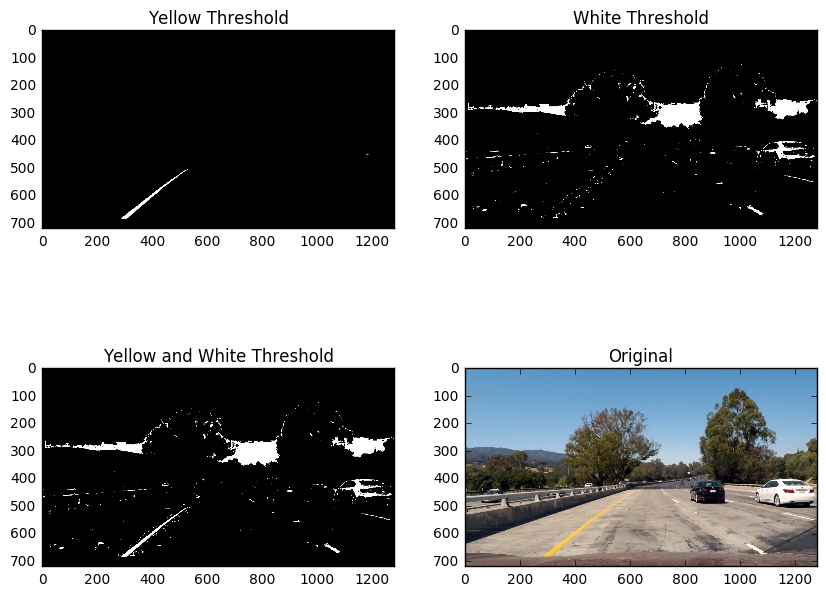

In [10]:
# Examples of yellow and white thresholds

img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/test4.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

yellow_min = np.array([0,150,150])
yellow_max = np.array([30,255,255])
white_min = np.array([19,0,180])
white_max = np.array([255,70,255])

yellow_thresh = HSV_thresh(img_RGB, yellow_min, yellow_max)
white_thresh = HSV_thresh(img_RGB, white_min, white_max)

combine_thresh = np.zeros_like(yellow_thresh)
combine_thresh[(yellow_thresh==1) | (white_thresh==1)] = 1

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.title('Yellow Threshold')
plt.imshow(yellow_thresh, cmap ='gray')

plt.subplot(2,2,2)
plt.title('White Threshold')
plt.imshow(white_thresh, cmap ='gray')

plt.subplot(2,2,3)
plt.title('Yellow and White Threshold')
plt.imshow(combine_thresh, cmap ='gray')
           
plt.subplot(2,2,4)
plt.title('Original')
plt.imshow(img_RGB)


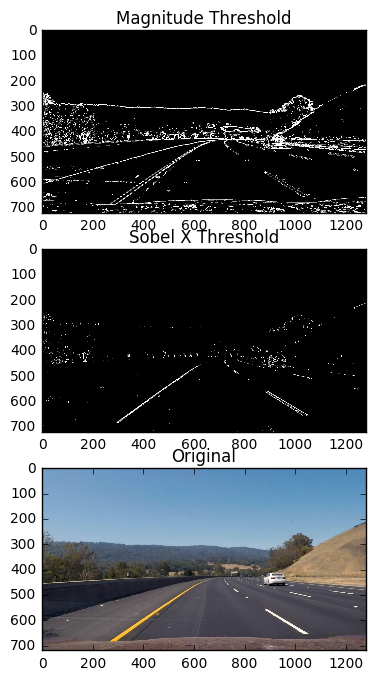

In [12]:
# Examples of magnitude and direction threshold function outputs
img = cv2.imread("test_images/test3.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mag_thresh =magnitude_thresh(img_RGB, 3, (20, 100))
sobel_thresh = sobel_x_thresh(img_RGB,3, 100, 220) 

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('Magnitude Threshold')
fig =plt.imshow(mag_thresh, cmap = 'gray')

plt.subplot(3,1,2)
plt.title('Sobel X Threshold')
fig =plt.imshow(sobel_thresh, cmap = 'gray')

plt.subplot(3,1,3)
plt.title('Original')
fig =plt.imshow(img_RGB)

I experimented with various color space transformations in order to see which one best detected the lanelines. Examples of these are included below.

The HSV and HLS color spaces seemed to perform the best at detecting lanelines.


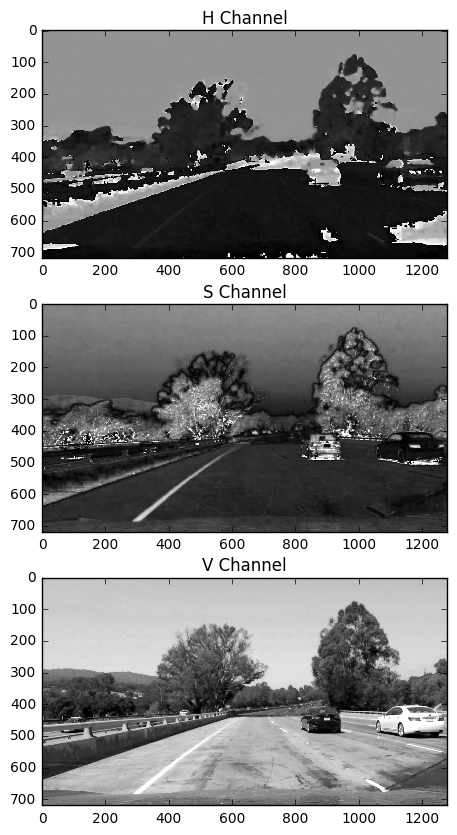

In [14]:
# Example image in HSV color space

img = cv2.imread("test_images/test1.jpg")
HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.title('H Channel')
fig =plt.imshow(HSV_img[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('S Channel')
fig =plt.imshow(HSV_img[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('V Channel')
fig =plt.imshow(HSV_img[:,:,2],cmap='gray')

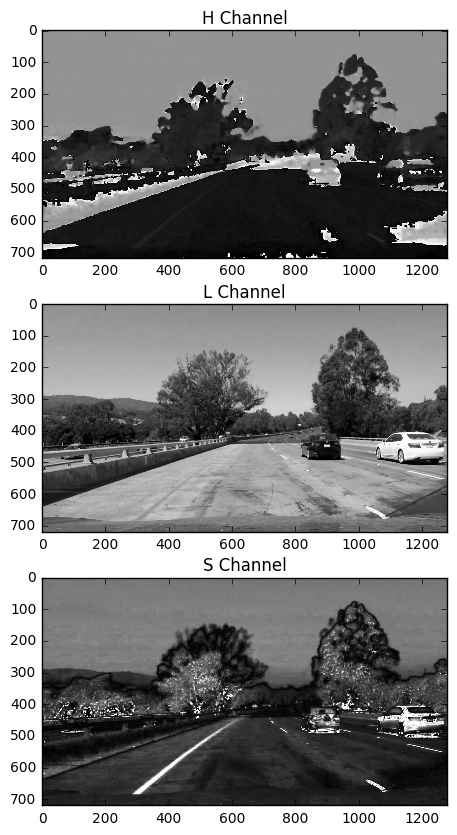

In [15]:
# Example image in HLS color space

img = cv2.imread("test_images/test1.jpg")
HLS_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.title('H Channel')
fig =plt.imshow(HLS_img[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('L Channel')
fig =plt.imshow(HLS_img[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('S Channel')
fig =plt.imshow(HLS_img[:,:,2],cmap='gray')

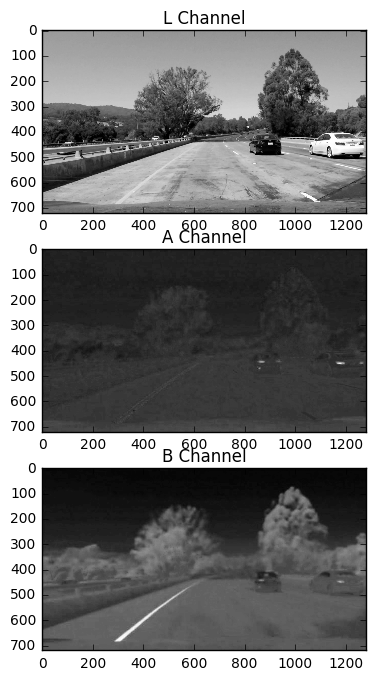

In [16]:
# Example image in LAB color space

img = cv2.imread("test_images/test1.jpg")
LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('L Channel')
fig =plt.imshow(LAB_img[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('A Channel')
fig =plt.imshow(LAB_img[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('B Channel')
fig =plt.imshow(LAB_img[:,:,2],cmap='gray')

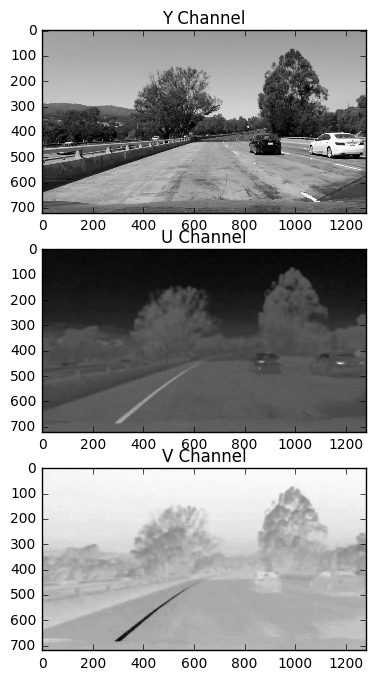

In [17]:
# Example image in YUV color space

img = cv2.imread("test_images/test1.jpg")
YUV_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('Y Channel')
fig =plt.imshow(YUV_img[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('U Channel')
fig =plt.imshow(YUV_img[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('V Channel')
fig =plt.imshow(YUV_img[:,:,2],cmap='gray')

# Perspective Transform

I utilized the CV2 getPerspectiveTransform() function to create a "birds-eye view" of the lane in front of the car. 

Below is an example images of the original view and birds-eye view. 


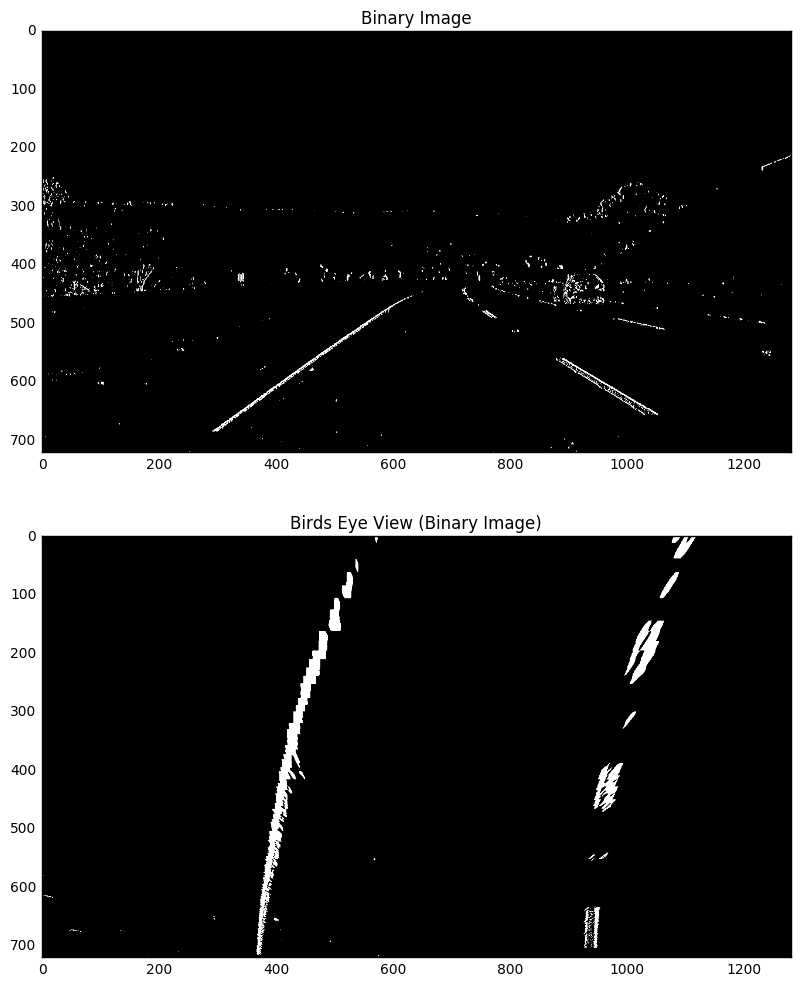

In [18]:
# Binary Perspective Transformation

src = np.float32([[600, 450], [200, 700], [1150, 700], [700, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

M_persp = cv2.getPerspectiveTransform(src, dst)
Minv_persp = cv2.getPerspectiveTransform(dst, src)
img_size = (sobel_thresh.shape[1], sobel_thresh.shape[0])
binary_warped = cv2.warpPerspective(sobel_thresh, M_persp, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(35,25))

plt.subplot(4,1,1)
plt.title('Binary Image')
fig =plt.imshow(sobel_thresh, cmap='gray')

plt.subplot(4,1,2)
plt.title('Birds Eye View (Binary Image)')
fig =plt.imshow(binary_warped, cmap='gray')

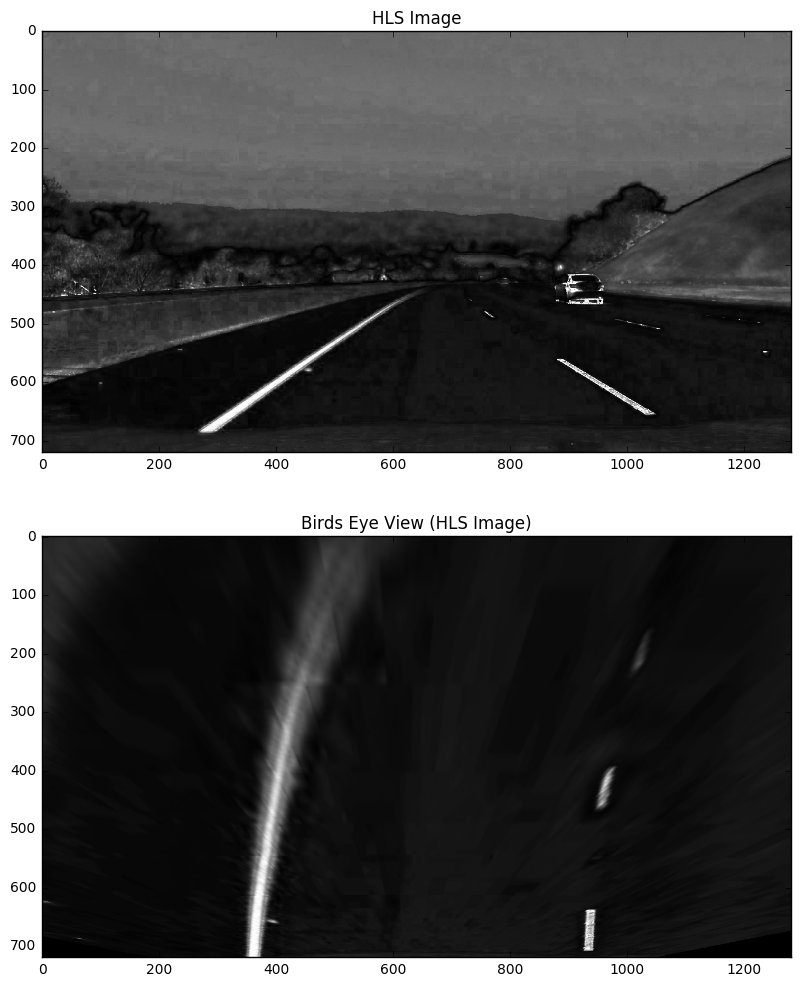

In [19]:
# HLS Perspective Transformation
img = cv2.imread("test_images/test3.jpg")
#img = cv2.imread("test_images/straight_lines2.jpg")

# Convert BGR to HLS color space
img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

undistort_img = cv2.undistort(img_HLS, mtx, dist, None, mtx)
img_size = (undistort_img.shape[1], undistort_img.shape[0])
HLS_warped = cv2.warpPerspective(undistort_img, M_persp, img_size, flags=cv2.INTER_LINEAR)

plt.figure(figsize=(35,25))

plt.subplot(4,1,1)
plt.title('HLS Image')
fig =plt.imshow(img_HLS[:,:,2], cmap='gray')

plt.subplot(4,1,2)
plt.title('Birds Eye View (HLS Image)')
fig =plt.imshow(HLS_warped[:,:,2], cmap='gray')

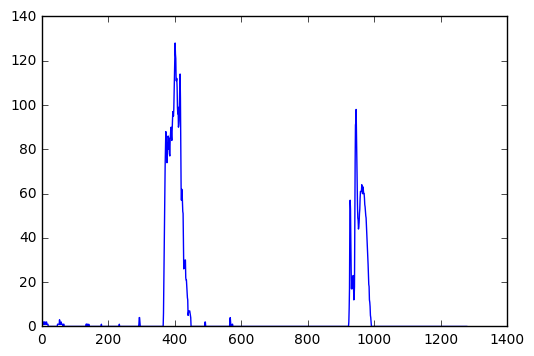

In [20]:
# Example histogram of left and right lane markings

histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [21]:
# Find the location of each laneline by looking for the two local maxima
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

hist_center = np.int(histogram.shape[0]/2)
left_lane = np.argmax(histogram[:hist_center])
right_lane = np.argmax(histogram[hist_center:]) + hist_center

print("Left lane position: ",left_lane)
print("Right lane position: ",right_lane)

Left lane position:  401
Right lane position:  946


# Laneline Detection and Polynomial Fit

I used the following function to search, detect, and fit both the left and right lanelines. The function outputs the coefficients for the two polynomials and also the output image of the lanelines and the best fit line for each.

In [22]:
def fit_lanelines(binary_warped):
    # Create histogram of the bottom half of the binary warped image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an blank image to draw on and visualize the results
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
   
    # Find the two peaks of the histogram (starting point for the left and right lines)
    hist_center = np.int(histogram.shape[0]/2)
    left_lane = np.argmax(histogram[:hist_center])
    right_lane = np.argmax(histogram[hist_center:]) + hist_center
    # Set the number of windows to fit the lanelines
    n_windows = 6
    # Set the height of windows
    window_height = np.int(binary_warped.shape[0]/n_windows)
    # Store the x and y positions of all nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = left_lane
    rightx_current = right_lane
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    min_pixel = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_indices = []
    right_lane_indices = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries 
        win_y_bottom = binary_warped.shape[0] - (window+1) * window_height
        win_y_top = binary_warped.shape[0] - window * window_height
        win_xleft_min = leftx_current - margin
        win_xleft_max = leftx_current + margin
        win_xright_min = rightx_current - margin
        win_xright_max = rightx_current + margin
        # Display the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_min, win_y_bottom),(win_xleft_max, win_y_top),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_min, win_y_bottom),(win_xright_max, win_y_top),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = ((nonzero_y >= win_y_bottom) & (nonzero_y < win_y_top) & (nonzero_x >= win_xleft_min) & (nonzero_x < win_xleft_max)).nonzero()[0]
        good_right_indices = ((nonzero_y >= win_y_bottom) & (nonzero_y < win_y_top) & (nonzero_x >= win_xright_min) & (nonzero_x < win_xright_max)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If greater min_pixel pixels are found, recenter next window on new position
        if len(good_left_indices) > min_pixel:
            leftx_current = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > min_pixel:        
            rightx_current = np.int(np.mean(nonzero_x[good_right_indices]))

    # Concatenate the arrays of indices
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    # Store left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices] 
    
    
    # Fit a second order polynomial to left/right lanelines
    if len(left_x) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(left_y, left_x, 2)
    
    if len(right_x) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(right_y, right_x, 2)

    
    out_img[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]


    return left_fit, right_fit, out_img

# Laneline Visualization with Polynomial Fit

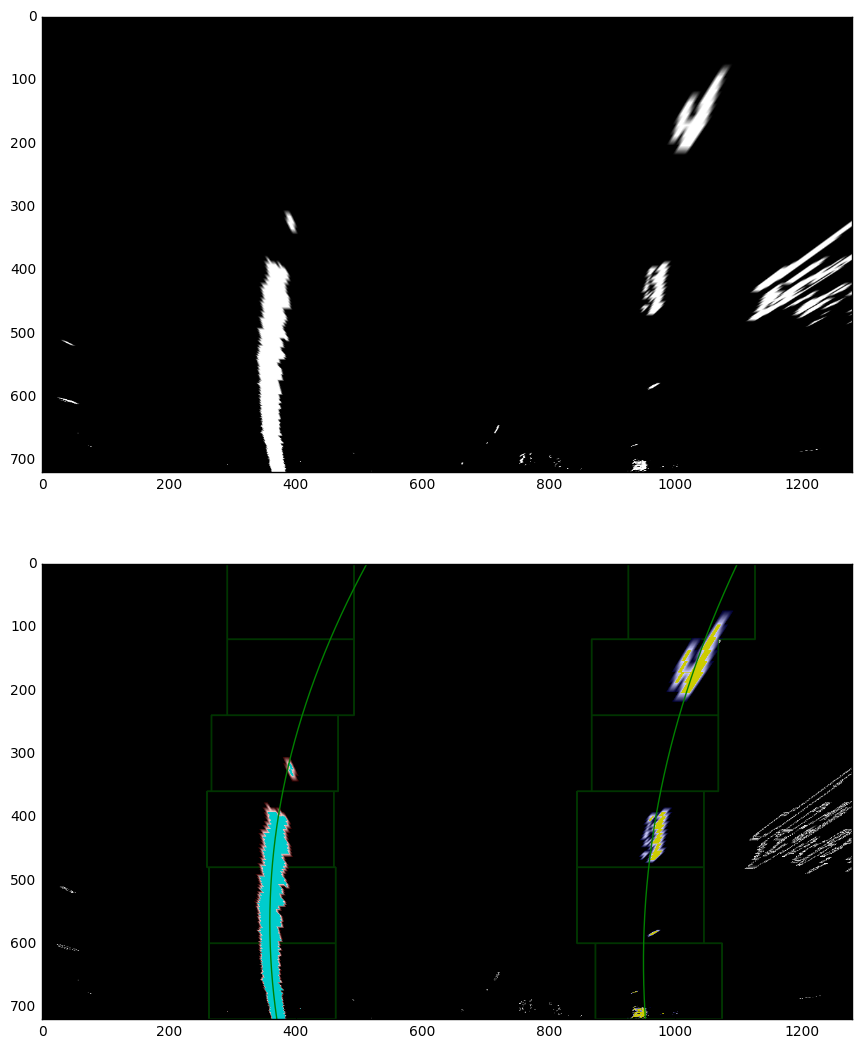

In [23]:
# Visualization of fitted lanelines
img = cv2.imread("test_images/test1.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undistorted = cv2.undistort(img_RGB, mtx, dist, None, mtx)

# Magnitude and Color Threshold    
yellow_min = np.array([0,100,100])
yellow_max = np.array([50,255,255])
white_min= np.array([25,0,180])
white_max = np.array([255,80,255])
global ref_left 
global ref_right
global left_fit
global right_fit

yellow_thresh = HSV_thresh(img_undistorted, yellow_min, yellow_max)
white_thresh = HSV_thresh(img_undistorted, white_min, white_max)
sobel_thresh = sobel_x_thresh(img_undistorted,9,80,220)

img_mag_thresh = np.zeros_like(yellow_thresh)
img_mag_thresh[(yellow_thresh==1) | (white_thresh==1) | (sobel_thresh==1)] = 1
img_mag_thresh[(yellow_thresh==1) | (white_thresh==1)] = 1


# Bird's Eye View
img_size = (img_mag_thresh.shape[1], img_mag_thresh.shape[0])
binary_warped = cv2.warpPerspective(img_mag_thresh, M_persp, img_size, flags=cv2.INTER_LINEAR)

left_fit, right_fit, out_img = fit_lanelines(binary_warped)

plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    
# Example image of laneline detection and polynomial fit     
plt.figure(figsize=(30,20))

plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')

plt.subplot(3,1,2)
plt.imshow(out_img)
plt.plot(left_fit_x, plot_y, color='green')
plt.plot(right_fit_x, plot_y, color='green')

plt.subplot(3,1,2)
binary_warped2 = np.zeros((720, 1280, 3))
binary_warped2[:,:,0] = binary_warped
binary_warped2[:,:,1] = binary_warped
binary_warped2[:,:,2] = binary_warped
plt.imshow(out_img)
result = cv2.addWeighted(binary_warped2, .8, out_img, .8, 0)
plt.imshow(result)


### Polynomial Fit Update Function

In [24]:
def fit(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 0
    left_lane_indices = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] - margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + left_fit[2] + margin))) 
    right_lane_indices = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] - margin)) & (nonzero_x < (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y + right_fit[2] + margin)))  

    # Collect left and right line pixel positions
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    
    # Fit a second order polynomial to each laneline
    if len(left_x) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(left_y, left_x, 2)
    
    
    if len(right_x) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(right_y, right_x, 2)
        
    return  left_fit_updated, right_fit_updated

# Calculation for Radius of Curvature

Below I used the function from the Udacity project 4 lesson. This function takes the polynomial fit coefficients as input along with the birds-eye view and calculates the offset distance the vehicle is from center. The function also calculates the radius of curvature for the left and right lanes as well as calibrates the distances in the images by calculating the number of meters per pixel in the x and y directions.

In [25]:
# Compute radius of curvature
def curvature(left_fit, right_fit, binary_warped):
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(plot_y)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curve_radius = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve_radius = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Calculated radius of curvature in meters
    return left_curve_radius, right_curve_radius, center

In [26]:
# Draw lanelines (green trapezoid) and return merged images 

def draw_lines(undistort_img, warped, left_fit, right_fit):
    # Create an blank image to draw the lines 
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    rgb_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    plot_y = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in 3D space
    left_fitx = left_fit[0]*plot_y**2+left_fit[1]*plot_y+left_fit[2]
    right_fitx = right_fit[0]*plot_y**2+right_fit[1]*plot_y+right_fit[2] 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_points = np.array([np.transpose(np.vstack([left_fitx, plot_y]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot_y])))])
    points = np.hstack((left_points, right_points))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(rgb_warp, np.int_([points]), (0, 255, 0))

    # Warp the blank image back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(rgb_warp, Minv_persp, (rgb_warp.shape[1], rgb_warp.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, new_warp, 0.3, 0)
    return(result, rgb_warp)

# Image/Video Pipelines

Here is the image/video pipeline which combines all of the individual steps from above and applies them to an image or multiple images (video).

In [32]:
# Function used to process the image/video
global counter
counter=0
ref_left =np.array([-0.0001,0,400])
ref_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   

def process_image(image):
    
    # Camera Calibration using previously calculated coefficeints 
    img_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    global counter
    
    # Magnitude and Color Threshold 
    yellow_min = np.array([0,100,100])
    yellow_max = np.array([50,255,255])
    white_min = np.array([28,0,180])
    white_max = np.array([255,80,255])
    global ref_left 
    global ref_right
    global left_fit
    global right_fit

    yellow_thresh = HSV_thresh(img_undistorted, yellow_min, yellow_max)
    white_thresh = HSV_thresh(img_undistorted, white_min, white_max)
    sobel_thresh = sobel_x_thresh(img_undistorted,9,80,220) 

    img_mag_thresh =np.zeros_like(yellow_thresh)
    img_mag_thresh[(yellow_thresh==1) | (white_thresh==1) | (sobel_thresh==1)] =1
        
    # Birds-eye View Perspective Transform
    img_size = (img_mag_thresh.shape[1], img_mag_thresh.shape[0])
    binary_warped = cv2.warpPerspective(img_mag_thresh, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    # Detect lanelines and fit with polynomials
    
    if counter==0:
        left_fit, right_fit,out_imgfit = fit_lanelines(binary_warped)
    else:
        left_fit, right_fit = fit(left_fit, right_fit, binary_warped)
        
    
    left_curve, right_curve, center_off = curvature(left_fit, right_fit, binary_warped)

    # Convert back to original and merge with original image    
    img_merge, img_birds = draw_lines(img_undistorted, binary_warped,left_fit, right_fit)

    # Setup the output image dimensions 
    img_out=np.zeros((576,1024,3), dtype=np.uint8)
    img_out[0:576,0:1024,:] =cv2.resize(img_merge,(1024,576))
    # Threshold Channels
    img_out[0:288,768:1024, 0] =cv2.resize(img_mag_thresh*255,(256,288))
    img_out[0:288,768:1024, 1] =cv2.resize(img_mag_thresh*255,(256,288))
    img_out[0:288,768:1024, 2] =cv2.resize(img_mag_thresh*255,(256,288))

    
    # Display curvature and relative position to center in image/s

    avg_curve = "Radius of Curvature: " + str(int((left_curve+right_curve)/4))+ "m"
    vehicle_center_dist = "Distance from Center: " + str(round( center_off,2)) + "m"
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, avg_curve, (100,140), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, vehicle_center_dist, (100,90), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    

    cv2.putText(img_out, "Threshold View", (800,30), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
      
    return img_out

In [33]:
#Test composition images
img = cv2.imread("test_images/test2.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_out=np.zeros((576,1024,3), dtype=np.uint8)
img_out[0:576,0:1024,0:3] =cv2.resize(img_RGB,(1024,576))

# Processed Images

## Image Pipeline

Below I have included examples of images before and after being processed. The images displays the radius of curvature, vehicle distance from center, vehicle lane area (colored green), and threshold view of image. 

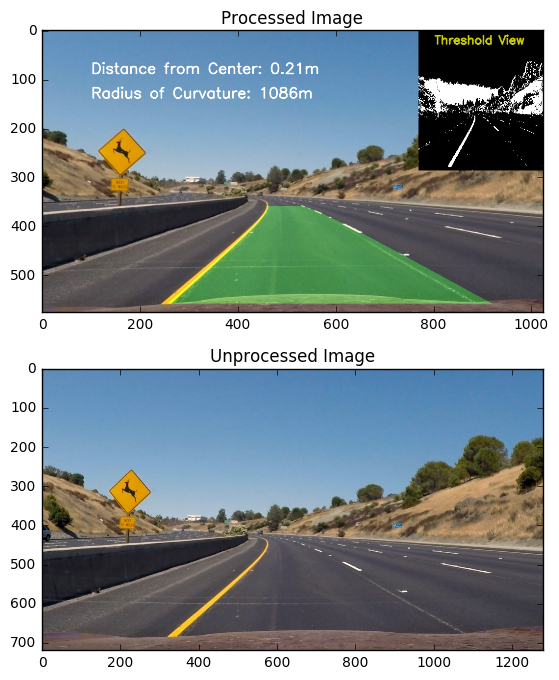

In [34]:
img = cv2.imread("test_images/test2.jpg")
#img = cv2.imread("test_images/straight_lines1.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2= process_image(img_RGB)
  
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title('Processed Image')
plt.imshow(img2)
plt.subplot(2,1,2)
plt.title('Unprocessed Image')
plt.imshow(img_RGB)

# Video Pipeline

In [36]:
# Create processed video file 
counter=0
output = 'processed_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(38,41)
#clip1 = VideoFileClip("challenge_video.mp4")


out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video processed_challenge_video.mp4
[MoviePy] Writing video processed_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:59<00:00,  3.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_challenge_video.mp4 

Wall time: 2min
0


In [37]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Project 4 Discussion

The pipeline I created works reasonably well for the project video. This is due to the fact that the threshold variables were specifically tuned for this video. The project video was also very uniform with clearly marked lane lines and the lighting was very uniform.  

However, the same pipeline does not work as well on the challenge video. This is because the lane area in the challenge video looks different and the color of the road surface changes in the middle of the lane. There is also a very dark shadow on the left side of the video and this seemed to throw off the video pipeline. The pipeline could possibly be improved by additional fine-tuning as well as utilizing a mask to ignore areas of the video that are not part of the road surface.

Possible cases where my pipeline would fail, include:
- Road surfaces with unclear lane markings
- Road surface with randomly changing visual appearance such as road repairs
- Any case where view of road surface in front of vehicle is reduced due to fog, rain, other vehicles, construction zones, etc.
    